In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random

# Dataset
 Name : Mnist
 
 Type : Image (1 channel)
 
 Task : Multi-class(10) classification
 
 description: mnist dataset contains handwritten digits from 0 to 9

In [4]:
from keras.datasets import mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()


In [5]:
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (60000, 28, 28)
y_train shape: (60000,)
X_test shape: (10000, 28, 28)
y_test shape: (10000,)


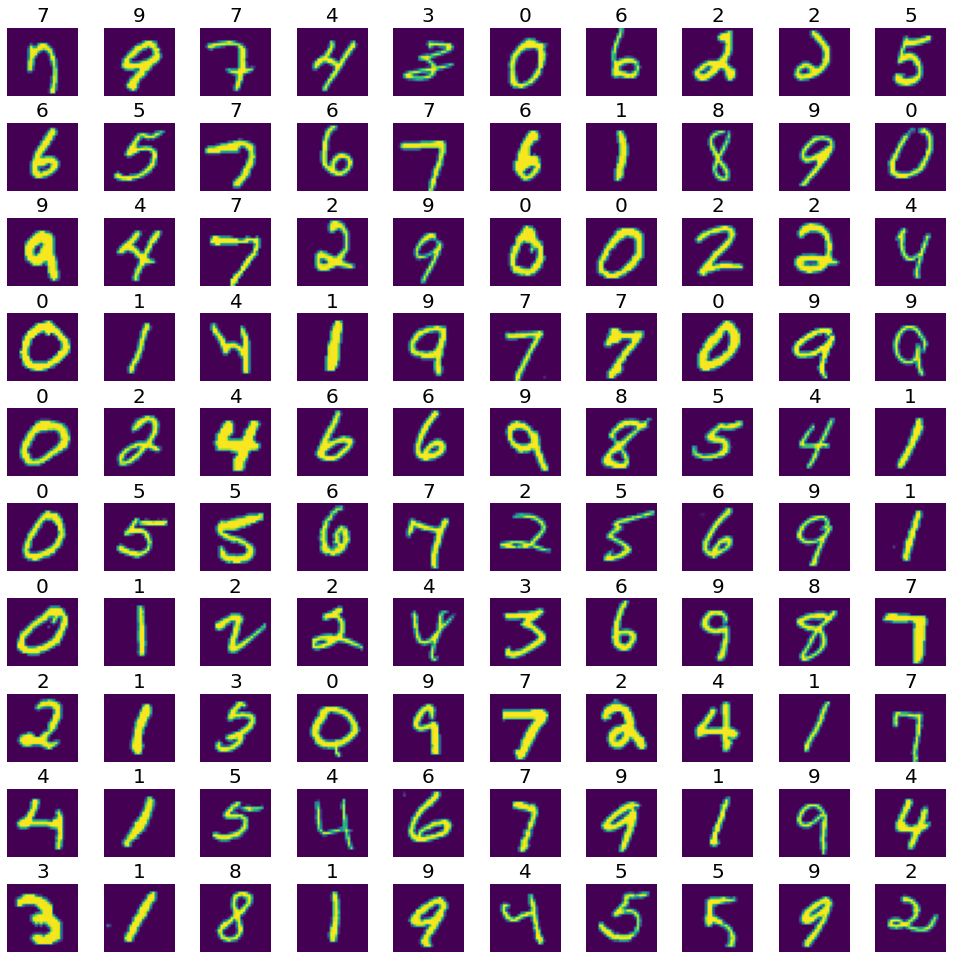

In [6]:
labels = [f"{i}" for i in range(10)]
W_grid = 10
L_grid = 10


fig, axes = plt.subplots(L_grid, W_grid, figsize = (17,17))

axes = axes.ravel() 

n_train = len(X_train) 

for i in np.arange(0, W_grid * L_grid): 

    index = np.random.randint(0, n_train)
    axes[i].imshow(X_train[index,1:])
    label_index = int(y_train[index])
    axes[i].set_title(labels[label_index], fontsize = 20)
    axes[i].axis('off')

plt.subplots_adjust(hspace=0.4)

Text(0.5, 1.0, 'Class distribution in training set')

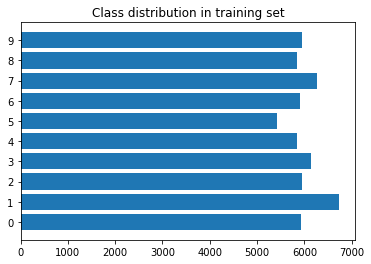

In [7]:
classes, counts = np.unique(y_train, return_counts=True)
plt.barh(labels, counts)
plt.title('Class distribution in training set')

In [17]:
X_train = X_train.reshape(60000, 28, 28, 1)
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1)
X_train_scaled = X_train / 255
X_test_scaled = X_test / 255

In [18]:
X_train.shape

(60000, 28, 28, 1)

In [10]:
from tensorflow.keras.utils import to_categorical
y_cat_train = to_categorical(y_train, 10)
y_cat_test = to_categorical(y_test, 10)

# DenseNet model

In [11]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping

def plot_history(history, title):
    
    plt.figure(figsize=(15,7))
    # Plot training & validation accuracy values
    plt.subplot(121)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')

    # Plot training & validation loss values
    plt.subplot(122)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

def evaluation_model(model, X_train, X_test, y_train, y_test):
  predictions = model.predict(X_test)
  predict_class = np.argmax(predictions, axis=1)
  predict_class = predict_class.tolist()
  predict_class = np.array(predict_class)
  y_test = y_test.reshape(1, -1)[0]
    
  miss_x_test = []
  miss_y_test = []
  for i in range(y_test.shape[0]):
    if y_test[i] != predict_class[i]:
      miss_x_test.append(X_test[i])
      miss_y_test.append((y_test[i], predict_class[i]))
  
  
  predictions = model.predict(X_train)
  predict_class = np.argmax(predictions, axis=1)
  predict_class = predict_class.tolist()
  predict_class = np.array(predict_class)
  y_train = y_train.reshape(1, -1)[0]
  
  miss_x_train = []
  miss_y_train = []
  for i in range(y_test.shape[0]):
    if y_train[i] != predict_class[i]:
      miss_x_train.append(X_train[i])
      miss_y_train.append((y_train[i], predict_class[i]))

  miss_count_per_class_train = {label:0 for label in labels}
  for miss in miss_y_train:
    miss_count_per_class_train[labels[miss[0]]] += 1

  print (miss_count_per_class_train)
  miss_count_per_class_test = {label:0 for label in labels}
  for miss in miss_y_test:
    miss_count_per_class_test[labels[miss[0]]] += 1
  
  return (miss_count_per_class_train, miss_count_per_class_test) , ((miss_x_train, miss_y_train), (miss_x_test, miss_y_test))

def miss_plot(miss1, miss2):
    plt.figure(figsize=(15,7))

    data = miss1
    names = list(data.keys())
    values = list(data.values())
    X_axis = np.arange(len(data))
    plt.bar(X_axis + 0.2, values,0.4, tick_label=names, label = "train data")
    
    data = miss2
    names = list(data.keys())
    values = list(data.values())

    X_axis = np.arange(len(data))
    plt.bar(X_axis - 0.2, values,0.4,  tick_label=names, label = "test data")
    
    plt.xticks(X_axis, names)
    plt.xlabel("Groups")
    plt.ylabel("Number of miss classification")
    plt.title("Number of miss classification in each group")
    plt.legend()
    
    plt.show()
    
early_stop = EarlyStopping(monitor='val_loss', patience=2)



In [27]:
from keras.callbacks import ReduceLROnPlateau
from keras.regularizers import l2
model = Sequential()
model.add(Flatten(input_shape=[28,28,1]))
model.add(Dense(512, activation='relu',
                  kernel_regularizer=l2(0)))
model.add(Dropout(0.25))
model.add(Dense(10, activation='softmax',
                  kernel_regularizer=l2(0)))

model.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics=['accuracy'])

lr_decay = ReduceLROnPlateau(monitor='loss', 
                             patience=1, verbose=0, 
                             factor=0.5, min_lr=1e-8)
# Train the model:
r = model.fit(X_train_scaled, y_cat_train, epochs=20, batch_size=128,
            callbacks=[lr_decay], validation_data = (X_test_scaled, y_cat_test), verbose=1)

Epoch 1/20
469/469 [==============================] - 8s 17ms/step - loss: 0.2909 - accuracy: 0.9160 - val_loss: 0.1449 - val_accuracy: 0.9582 - lr: 0.0010
Epoch 2/20
469/469 [==============================] - 5s 11ms/step - loss: 0.1286 - accuracy: 0.9615 - val_loss: 0.0979 - val_accuracy: 0.9699 - lr: 0.0010
Epoch 3/20
469/469 [==============================] - 5s 11ms/step - loss: 0.0901 - accuracy: 0.9731 - val_loss: 0.0845 - val_accuracy: 0.9739 - lr: 0.0010
Epoch 4/20
469/469 [==============================] - 5s 11ms/step - loss: 0.0692 - accuracy: 0.9791 - val_loss: 0.0686 - val_accuracy: 0.9793 - lr: 0.0010
Epoch 5/20
469/469 [==============================] - 5s 11ms/step - loss: 0.0553 - accuracy: 0.9832 - val_loss: 0.0674 - val_accuracy: 0.9780 - lr: 0.0010
Epoch 6/20
469/469 [==============================] - 5s 11ms/step - loss: 0.0457 - accuracy: 0.9862 - val_loss: 0.0660 - val_accuracy: 0.9798 - lr: 0.0010
Epoch 7/20
469/469 [==============================] - 5s 11ms/st

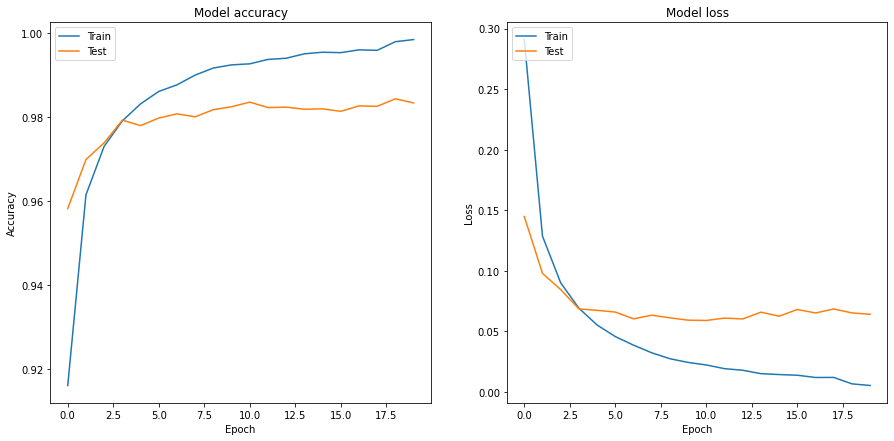

In [28]:
plot_history(r, 'Dense model')


In [29]:
(miss_count_train, miss_count_test), (miss_train, miss_test) = evaluation_model(model, X_train_scaled, X_test_scaled, y_train, y_test)

1875/1875 [==============================] - 5s 2ms/step
{'0': 0, '1': 0, '2': 0, '3': 0, '4': 0, '5': 0, '6': 0, '7': 0, '8': 0, '9': 0}


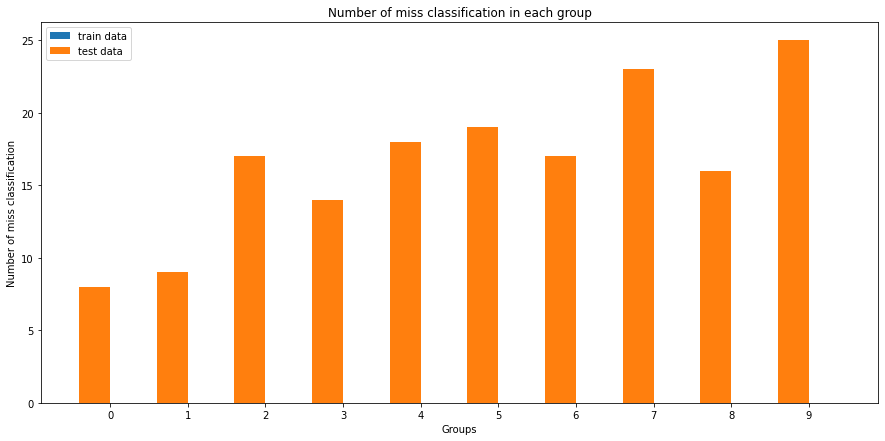

In [30]:
miss_plot(miss_count_train, miss_count_test)

# T-SNE embedding for clustering

In [31]:
miss_x_train = np.array(miss_train[0])
miss_y_train = miss_train[1]
miss_y_train_true = [i for (i, j) in miss_y_train]
miss_y_train_false = [j for (i, j) in miss_y_train]

miss_x_test = np.array(miss_test[0])
miss_y_test = miss_test[1]
miss_y_test_true = [i for (i, j) in miss_y_test]
miss_y_test_false = [j for (i, j) in miss_y_test]


In [33]:
from sklearn.manifold import TSNE
tsne = TSNE(
        n_components=2,
        n_iter=500,
        n_iter_without_progress=150,
        n_jobs=2,
        random_state=0,
    )
projections = mnist_tr = tsne.fit_transform(miss_x_test.reshape(miss_x_test.shape[0], 28 * 28))

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


In [34]:
cps_df = pd.DataFrame(columns=['CP1', 'CP2', 'target'],
                       data=np.column_stack((projections, 
                                            miss_y_test_true)))# cast targets column to int
cps_df.loc[:, 'target'] = cps_df.target.astype(int)
cps_df.head()

,CP1,CP2,target
0,2.130957,3.456020,4
1,-2.481385,4.365085,2
2,0.548393,-4.922513,9
3,-9.523839,0.905983,4
4,5.199088,4.985221,9


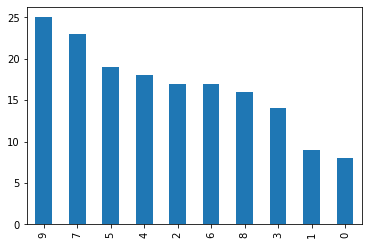

In [35]:
cps_df.target.value_counts().plot(kind='bar')

/usr/local/lib/python3.8/dist-packages/seaborn/axisgrid.py:337: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


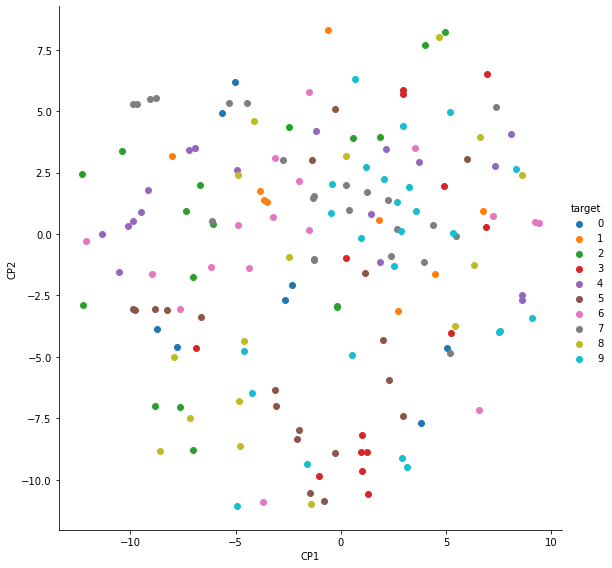

In [36]:
grid = sns.FacetGrid(cps_df, hue="target", size=8)
grid.map(plt.scatter, 'CP1', 'CP2').add_legend()